In [1]:
'''
Useful links:
Data preprocessing: https://www.kaggle.com/parthsharma5795/comprehensive-twitter-airline-sentiment-analysis
Train ULMFit in IMDB: https://course.fast.ai/videos/?lesson=8
'''

'\nUseful links:\nData preprocessing: https://www.kaggle.com/parthsharma5795/comprehensive-twitter-airline-sentiment-analysis\nTrain ULMFit in IMDB: https://course.fast.ai/videos/?lesson=8\n'

In [ ]:
# If you are running the notebook in COLAB run the following lines of code
!pip install torch==1.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install fastai==2.1.4

In [3]:
from fastai.text.all import *
import torch
import re
# import os
# from os import listdir
# from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display,HTML

In [4]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [5]:
url = 'https://raw.githubusercontent.com/arnaujc91/ULMFit/master/data/Tweets.csv'
tweets = pd.read_csv(url)

## Analyse the data

In [6]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
display(HTML(tweets.to_html(columns=['text'], index=False,header=None, max_rows=20)))

@VirginAmerica What @dhepburn said.
@VirginAmerica plus you've added commercials to the experience... tacky.
@VirginAmerica I didn't today... Must mean I need to take another trip!
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
@VirginAmerica and it's a really big bad thing about it
@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)"
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
"@virginamerica Well, I didn't…but NOW I DO! :-D"
"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."
...


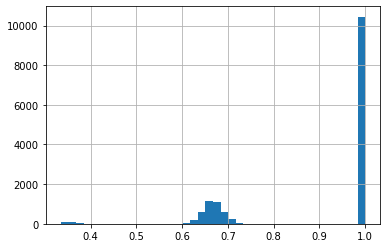

In [8]:
tweets.airline_sentiment_confidence.hist(bins=40)

In [9]:
tweets.airline_sentiment.value_counts()/len(tweets)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

Later on we can also use this same model to predict the reason of the complaint:

In [10]:
tweets.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [11]:
'''If you downloaded the file and have it in a "data" directory,
        uncomment and run the lines below'''
# data_directory = Path(os.getcwd())/'data'
# assert data_directory.is_dir(), 'Data directory not found'
# data_files = listdir(data_directory)
# print(data_files)

# csv_datafile = data_directory/'Tweets.csv'
# print('Data file:', csv_datafile)
# tweets = pd.read_csv(csv_datafile)
# tweets

'If you downloaded the file and have it in a "data" directory,\n        uncomment and run the lines below'

Every tweet starts with a [Twitter handle](https://sproutsocial.com/glossary/twitter-handle/) which refers to the Airline, to which the twitter message is adressed to. E.g:

In [12]:
list(tweets.text[:5]), list(tweets.airline[:5])

(['@VirginAmerica What @dhepburn said.',
  "@VirginAmerica plus you've added commercials to the experience... tacky.",
  "@VirginAmerica I didn't today... Must mean I need to take another trip!",
  '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
  "@VirginAmerica and it's a really big bad thing about it"],
 ['Virgin America',
  'Virgin America',
  'Virgin America',
  'Virgin America',
  'Virgin America'])

We want to remove this information. In order to do so we add a new rule to the [default rules](https://github.com/fastai/fastai/blob/a8ed5a64f93df9be02eef907ddbc355f3ad130d1/fastai/text/core.py#L96) for preprocessing text:

In [13]:
def rm_first_handle(t):
    return re.sub(r'^@\w* ', '', t)

rules = defaults.text_proc_rules
rules.insert(0, rm_first_handle)

**IMPORTANT**: If you run the previous line of code the rules will be modified for the whole Notebook. So later on this will also affect the DataLoaders!

Now let's tokenize the tweets:

In [ ]:
tokenized_df, vocab_count = tokenize_df(tweets,  text_cols='text', tok=SpacyTokenizer())
vocab = list(vocab_count.keys())
print(len(vocab))
print(vocab[:5])

In [15]:
tokenized_df.text[:5]

0                                                                                                          [xxbos, xxmaj, what, @dhepburn, said, .]
1                                                                     [xxbos, plus, you, 've, added, commercials, to, the, experience, …, tacky, .]
2                                                            [xxbos, i, did, n't, today, …, xxmaj, must, mean, i, need, to, take, another, trip, !]
3    [xxbos, it, 's, really, aggressive, to, blast, obnoxious, ", entertainment, ", in, your, guests, ', faces, &, &, they, have, little, recourse]
4                                                                                       [xxbos, and, it, 's, a, really, big, bad, thing, about, it]
Name: text, dtype: object

*tokenize_df* returns the tokenized dataframe and also the counting of the tokenized words in the dataset. For example if we want to get all the words that appear at least 3 times, we can write the following code:

In [16]:
len([key for key in vocab_count if vocab_count[key]>2])

4683

So 4683 words appear **at least** 3 times in the entire dataset.

We can now compare the tokenized VS the original tweets:



In [17]:
i = 0
for a,b in zip(list(tokenized_df.text), list(tweets.text)):
    print('before: ', b)
    print('after: ', ' '.join(a))
    print('\n')
    if i == 5:
        break
    i+=1

before:  @VirginAmerica What @dhepburn said.
after:  xxbos xxmaj what @dhepburn said .


before:  @VirginAmerica plus you've added commercials to the experience... tacky.
after:  xxbos plus you 've added commercials to the experience … tacky .


before:  @VirginAmerica I didn't today... Must mean I need to take another trip!
after:  xxbos i did n't today … xxmaj must mean i need to take another trip !


before:  @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
after:  xxbos it 's really aggressive to blast obnoxious " entertainment " in your guests ' faces & & they have little recourse


before:  @VirginAmerica and it's a really big bad thing about it
after:  xxbos and it 's a really big bad thing about it


before:  @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
after:  xxbos seriously would pay $ 30 a flight for seats t

## Create the DataLoaders

In [18]:
# TODO: Random splitting is not a good idea, we have to see what are the distributions of labels of the tweets.
# For example if we have 80% negative tweets in training and 20% positive and then the other way around in validation
# This might not be optimal. In particular we should have a homogenous distribution of tweets in the training set
# in order to not have a bias towards a particular classifciation. 80% neg => Bias towards neg tweet classification.

In [19]:
# For an explanation of this function go back to "Analyse the data" section.
def rm_first_handle(t):
    return re.sub(r'^@\w* ', '', t)

rules = defaults.text_proc_rules
rules.insert(0, rm_first_handle)

We will now create a [TextDataLoader](https://docs.fast.ai/text.data#TextDataLoaders) which is a Wrapper around the [DataLoader](https://docs.fast.ai/data.core.html#DataLoaders) class. The DataLoader splits our dataset between training and validation. The TextDataLoader adds more functionality specific to NLP problems, like the vocabulary of the data.

Now a few things:
- Remember that the TextDataLoaders just consider a word as part of the vocab if it appears **more than 3 times** in the entire dataset by default if you use `TextDataLoaders.from_df`.
- We also need `is_lm=True` because we will first train a **Language Model**.

In [20]:
lm_dls = TextDataLoaders.from_df(tweets, text_col='text',  is_lm=True)
lm_dls.show_batch(max_n=5)

,text,text_
0,"xxbos well this one missed the mark . xxmaj she was in a xxunk from the minute i xxunk up to the counter xxbos once again your customer service at the providence airport was horrible . xxmaj do you actually care about customers or just making money ? xxbos now we have to wait , and wait to get it straight . i fly you for personal and business . xxmaj but","well this one missed the mark . xxmaj she was in a xxunk from the minute i xxunk up to the counter xxbos once again your customer service at the providence airport was horrible . xxmaj do you actually care about customers or just making money ? xxbos now we have to wait , and wait to get it straight . i fly you for personal and business . xxmaj but now"
1,info for her new flight . xxmaj basic customer service xxbos .@united board customers onto a plane with no pilot ? xxmaj the only thing that expedited was my time in line to book a new flight . xxmaj come on now . xxbos thanks for making my trip home # xxunk next # brandmance flight xxmaj i 'll take more xxunk ! # xxup love # travel # business xxbos was,for her new flight . xxmaj basic customer service xxbos .@united board customers onto a plane with no pilot ? xxmaj the only thing that expedited was my time in line to book a new flight . xxmaj come on now . xxbos thanks for making my trip home # xxunk next # brandmance flight xxmaj i 'll take more xxunk ! # xxup love # travel # business xxbos was there
2,! xxmaj guess i should just hang up & & give up on using my award miles before prices jump ? xxmaj xxunk thanks http : / / t.co / xxunk xxbos xxmaj how do i place it on hold and complete payment ? i do n't see any way to do that from my reservations page . xxbos xxmaj have a cup coffee and relax while you check out the xxmaj,xxmaj guess i should just hang up & & give up on using my award miles before prices jump ? xxmaj xxunk thanks http : / / t.co / xxunk xxbos xxmaj how do i place it on hold and complete payment ? i do n't see any way to do that from my reservations page . xxbos xxmaj have a cup coffee and relax while you check out the xxmaj new
3,xxbos why does it feel like xxmaj i 'm being xxunk and dime to enjoy a flight with xxup aa ? i purchased a tkt but have to pay extra for a seat xxbos xxmaj can you bring xxunk xxunk in small pet carrier onboard your flights ? xxbos 20 min more delays to flt xxunk at sfo 2 load 2 more pax makes no sense . xxmaj will strand many of,why does it feel like xxmaj i 'm being xxunk and dime to enjoy a flight with xxup aa ? i purchased a tkt but have to pay extra for a seat xxbos xxmaj can you bring xxunk xxunk in small pet carrier onboard your flights ? xxbos 20 min more delays to flt xxunk at sfo 2 load 2 more pax makes no sense . xxmaj will strand many of us
4,"they just kept putting me on hold and still did n't fix the problem xxbos iphone app now has passbook support ! xxmaj xxunk ! xxmaj it 's the little things in life … 😜 xxbos xxmaj sent an email more than 24 hours ago asking a few questions , still no response . xxmaj need answers before ( hopefully ) xxmaj flight xxmaj booking xxmaj problems flight … xxbos xxup lauren","just kept putting me on hold and still did n't fix the problem xxbos iphone app now has passbook support ! xxmaj xxunk ! xxmaj it 's the little things in life … 😜 xxbos xxmaj sent an email more than 24 hours ago asking a few questions , still no response . xxmaj need answers before ( hopefully ) xxmaj flight xxmaj booking xxmaj problems flight … xxbos xxup lauren xxup"


Let's see a little bit the structure of this dataloader:

In [21]:
lm_dls._docs

{'__getitem__': 'Retrieve `DataLoader` at `i` (`0` is training, `1` is validation)',
 'cpu': 'Use the cpu',
 'cuda': 'Use the gpu if available',
 'from_dblock': 'Create a dataloaders from a given `dblock`',
 'new_empty': 'Create a new empty version of `self` with the same transforms',
 'to': 'Use `device`',
 'train': 'Training `DataLoader`',
 'train_ds': 'Training `Dataset`',
 'valid': 'Validation `DataLoader`',
 'valid_ds': 'Validation `Dataset`'}

The previous DataLoader was for training or fine tunning the language model. The following one will be the DataLoader used for **classification**.

In [22]:
tc_dls = TextDataLoaders.from_df(tweets, text_col='text', label_col='airline_sentiment')
tc_dls.show_batch(max_n=8)

,text,category
0,xxbos xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - jac 29 / 9 xxup jac - lax 8 / 10 xxup lax - dub 13 / 10 . xxmaj i 'm * xxunk xxmaj what is checked bag allowance for xxup jac - lax ?,neutral
1,xxbos i xxup just xxup asked xxup my xxup boyfriend xxup to xxup xxunk xxup over xxup the xxup xxunk xxup on xxup flight xxunk xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever xxrep 3 ! xxup thank u xxup so xxup much xxrep 6 !,positive
2,xxbos xxmaj many xxmaj thanks for the xxmaj follow . \n▁ # xxunk # xxunk # xxup usa # xxmaj xxunk \n xxmaj looking for xxmaj any xxmaj help 😍 \n 💗 🇬 🇧 💗 🇺 🇸 💗 \n 🎀 xxunk 🎀 http : / / t.co / xxunk,neutral
3,"xxbos 4 segments , 4 / 4 delayed . xxmaj gnv > xxup ctl . xxup ctl > xxup jan . xxup jan > xxup ctl . xxup ctl > xxup gnv . xxmaj my year off from flying with you guys was the way to go .",negative
4,xxbos xxup poor xxup experience 2day at ord xxunk . 8 xxunk . w / 3 cust . 10 waiting . xxmaj asked to speak w / supervisor . xxmaj told 20 min . xxmaj in a mtg ! ! xxmaj what ? ! ? !,negative
5,xxbos xxup fail xxmaj you xxmaj cancelled xxmaj flightled our flight frm xxup xxunk and then used our reserv home to xxup iah ( from xxup sea ) for reflight xxmaj booking xxmaj problems w / out xxup our xxup xxunk ! ! # xxup xxunk,negative
6,xxbos xxup but @united just re - booked to xxup bos ; xxup xxunk ! ! now 3 hour bus to xxup xxunk home . xxmaj could have flown to xxup bdl & & back to xxup dc in same time . # unitedairlines,negative
7,"xxbos xxup by xxup the xxup grace xxup of xxup god , i xxup made xxup it ! “ @usairways : xxunk _ _ xxmaj we do n't have those xxunk in here . xxmaj we hope you can make that flight . ”",positive


From the code of `TextDataLoaders.from_df` we can see that the vocab is created with words that appear **at least 3 times** in the entire dataset. Any words that appear with a lower frequency will be automatically tokenized as `xxunk`, which stands for *unknown*.

So far the words in the vocab are words that appear at least 3 times in the entire dataset, if we want to change that, we can not do it directly from the high level API that fastai offers, but instead we need a couple of more lines of code. Anyway the following lines are just what `TextDataLoaders.from_df` does but changing the parameter **min_freq** to one.

In [ ]:
'''
If you wanna have a TextDataLoader with words that appear less than 3 times in the dataset:
'''

# we set min_freq to ONE to allow any words that appear at least once.
min_freq=1

dblock = DataBlock(blocks=[TextBlock.from_df(text_cols='text', is_lm=True, min_freq=min_freq) ],
                           get_x=ColReader("text"),
                           splitter = RandomSplitter(valid_pct=0.2))

tweets_f1 = TextDataLoaders.from_dblock(dblock, tweets)

Another issue is that eventhough `TextDataLoaders.from_df` call `tokenize_df`, the first will add some extra special tokens that are not provided by `tokenize_df`. Let's see what this means:

In [45]:
print('Length of vocabulary obtained from: ')
print(f'\n   - tokenize_df: {len(set(vocab))}')
print(f'\n   - TextDataLoaders.from_df (min_freq=3): {len(lm_dls.vocab)}')
print(f'\n   - TextDataLoaders.from_dblock (min_freq=1): {len(tweets_f1.vocab)}')


Length of vocabulary obtained from: 

   - tokenize_df: 15740

   - TextDataLoaders.from_df (min_freq=3): 4664

   - TextDataLoaders.from_dblock (min_freq=1): 15752


A priori you would expect that the vocab from `tokenize_df`and `TextDataLoaders.from_dblock` to be the same size as both obtain the vocab from any word that appears in the dataset. Despite of this one has 7 more items than the other. Which are those items?

In [27]:
def vocab_diff(vocab1, vocab2):
    if len(vocab1)>len(vocab2):
        b_vocab = set(vocab1)
        s_vocab = set(vocab2)
    else:
        b_vocab = set(vocab2)
        s_vocab = set(vocab1)
        
    return list(b_vocab-s_vocab.intersection(b_vocab))
        

The added special tokens from `TextDataLoaders.from_df` are:

In [46]:
vocab_diff(tweets_f1.vocab, vocab)

['xxeos', 'xxfake', 'xxfld', 'xxpad', 'xxunk']

Besides, for some reason the special token `xxfake` appears twice in the vocab from `tweets_f1` (probably a bug):

In [ ]:
import collections
print({item:count for item, count in collections.Counter(tweets_f1.vocab).items() if count > 1})

In [44]:
vocab_diff([key for key in vocab_count if vocab_count[key]>2], lm_dls.vocab)

['xxeos', 'xxfake', 'xxfld', 'xxpad', 'xxunk']

## Some tools for debugging the data

A useful tool for debugging can be to find some word in the original texts, for example:

In [33]:
tweets.text[tweets.text.str.contains('think the US site allows that ', regex=False)]

11108    @usairways I don't think the US site allows that (unlike http://t.co/etfjqIwUvt). Can I use a US credit if I held on http://t.co/etfjqIwUvt?
Name: text, dtype: object

The word "*explaining*" appears twice in the dataset, once in row 2279 and once in row 14225

Another useful tool is to decode the numericalized datasets:

In [50]:
decoded = lm_dls.train_ds.decode(lm_dls.train_ds)

In [ ]:
lm_dls.train_ds[0], decoded[0]

The dictionary between tokenized words and integers is found inside the [Numericalize](https://docs.fast.ai/text.data#Numericalize) class:

In [ ]:
lm_dls.train_ds.numericalize.o2i

In [ ]:
# [lm_dls.train_ds.numericalize.o2i[word] for word in decoded[0][0].split()]

Also useful:

In [53]:
for text in decoded:
        if 'xxeos' in text[0]:
            print(text[0])

## Training

Make sure that the vocabs of the classifier and the Language Model are the same (as a crosscheck):

In [54]:
assert set(lm_dls.vocab) == set(tc_dls.vocab[0]), 'Vocabs are not equal!'

Now let's define the [Callbacks](https://docs.fast.ai/callback.tracker) we are going to use:
- [ActivationStats](https://docs.fast.ai/callback.hook#ActivationStats): Callback that record the mean and std of activations.
- [ShowGraphCallback](https://docs.fast.ai/callback.progress#ShowGraphCallback): Update a graph of training and validation loss
- [ParamScheduler](https://docs.fast.ai/callback.schedule#ParamScheduler): We are not going to use it in this guide, but it is definitely interesting to play with it. It allows to change the learning rate at different stages of the training and also to have a different learning rate scheduler for every parameter group. 

In [55]:
cbs = [
       ShowGraphCallback,
       ActivationStats(with_hist=True),
       SaveModelCallback
#        ParamScheduler(sched)
      ]

Now let's create the learner. The [Learner](https://docs.fast.ai/learner) class is the class that contains everything necessary for training. It contains:
- DataLoaders
- Model
- Loss function
- Optimizer 
- Splitter to split the model in several parameter groups
- Callbacks for the training.
- etc.

In the following line we will pass as arguments to the function [language_model_learner](https://docs.fast.ai/text.learner#language_model_learner): 
- The DataLoader
- The name of the model: [AWS_LSTM](https://docs.fast.ai/text.models.awdlstm)
- The Callbacks
- The path were we wanna save the trained model or part of the model, e.g. just the encoder

In [56]:
learner = language_model_learner(lm_dls, AWD_LSTM, cbs=cbs, metrics=[accuracy])

We can see that there are already certain Callbacks which are set up by default:

In [57]:
list(learner.cbs)

[TrainEvalCallback,
 Recorder,
 ProgressCallback,
 ShowGraphCallback,
 ActivationStats,
 SaveModelCallback,
 ModelResetter,
 RNNRegularizer]

The following code shows the layers of the language model:

In [58]:
modules = [m for m in flatten_model(learner.model) if has_params(m)]; modules

[Embedding(4664, 400, padding_idx=1),
 Embedding(4664, 400, padding_idx=1),
 LSTM(400, 1152, batch_first=True),
 ParameterModule(),
 LSTM(1152, 1152, batch_first=True),
 ParameterModule(),
 LSTM(1152, 400, batch_first=True),
 ParameterModule(),
 Linear(in_features=400, out_features=4664, bias=True)]

And we will do the same for the Learner of the Text Classifier:

In [68]:
learn = text_classifier_learner(tc_dls, AWD_LSTM, drop_mult=0.5, cbs=cbs, metrics=[accuracy, F1Score(average='micro')]).to_fp16()

In [60]:
list(learn.cbs)

[TrainEvalCallback,
 Recorder,
 ProgressCallback,
 ShowGraphCallback,
 ActivationStats,
 SaveModelCallback,
 ModelResetter,
 RNNRegularizer,
 ModelToHalf,
 MixedPrecision]

By default when we load a pretrained model with the `language_model_learner`, not all the layers are trainable, to see which layers are potentially trainable we use the following code:

In [61]:
def requires_grad_bool(m:nn.Module)->Optional[bool]:
    ps = list(m.parameters())
    return ps[0].requires_grad

def trainable_layers(learn):
  modules = [m for m in flatten_model(learn.model) if has_params(m)]
  for it in modules:
    print(f"{requires_grad_bool(it)}  -- ",it)

In [62]:
trainable_layers(learner)

True  --  Embedding(4664, 400, padding_idx=1)
True  --  Embedding(4664, 400, padding_idx=1)
False  --  LSTM(400, 1152, batch_first=True)
False  --  ParameterModule()
False  --  LSTM(1152, 1152, batch_first=True)
False  --  ParameterModule()
False  --  LSTM(1152, 400, batch_first=True)
False  --  ParameterModule()
True  --  Linear(in_features=400, out_features=4664, bias=True)


Now we are going to try to find the best learning rate for our models, in order to do so I recommend to check the follwing question asked in stackoverflow --> [choosing-the-learning-rate-using-fastais-learn-lr-find](https://stackoverflow.com/questions/61172627/choosing-the-learning-rate-using-fastais-learn-lr-find)


SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.033113110810518265)

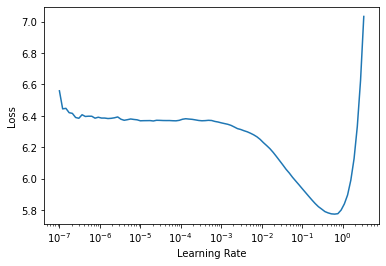

In [63]:
learner.lr_find()

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.12022644281387329)

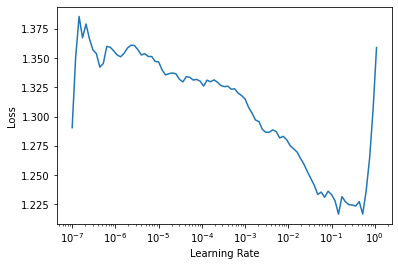

In [64]:
learn.lr_find()

Now let's follow the receipt from Jeremy Howard in his [paper](https://arxiv.org/abs/1801.06146). It is important to understand whats the difference between `fit`and `fit_one_cycle` (for that take a look [here](https://iconof.com/1cycle-learning-rate-policy/)). Also as you will see we will progressively unfreeze the layers during training, this is seen to perform better than just `fit`.

In [65]:
??learner.fit_one_cycle

epoch,train_loss,valid_loss,accuracy,time
0,5.550419,4.438898,0.216756,00:23
1,4.756847,4.039219,0.260647,00:24
2,4.391785,3.959997,0.267890,00:24
3,4.186729,3.925690,0.273532,00:24
4,4.053167,3.907963,0.274618,00:24
5,3.956077,3.887491,0.276638,00:24
6,3.874323,3.876591,0.280016,00:24
7,3.820242,3.867254,0.281670,00:24
8,3.770400,3.862471,0.282145,00:24
9,3.728679,3.861717,0.282335,00:24


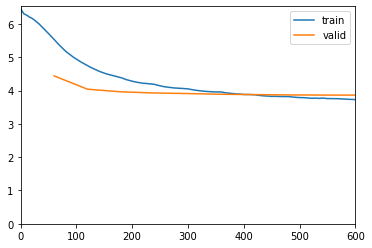

Better model found at epoch 0 with valid_loss value: 4.438898086547852.
Better model found at epoch 1 with valid_loss value: 4.039219379425049.
Better model found at epoch 2 with valid_loss value: 3.9599967002868652.
Better model found at epoch 3 with valid_loss value: 3.925690174102783.
Better model found at epoch 4 with valid_loss value: 3.9079630374908447.
Better model found at epoch 5 with valid_loss value: 3.8874905109405518.
Better model found at epoch 6 with valid_loss value: 3.876591205596924.
Better model found at epoch 7 with valid_loss value: 3.8672544956207275.
Better model found at epoch 8 with valid_loss value: 3.8624706268310547.
Better model found at epoch 9 with valid_loss value: 3.8617172241210938.
True  --  Embedding(4664, 400, padding_idx=1)
True  --  Embedding(4664, 400, padding_idx=1)
False  --  LSTM(400, 1152, batch_first=True)
False  --  ParameterModule()
False  --  LSTM(1152, 1152, batch_first=True)
False  --  ParameterModule()
False  --  LSTM(1152, 400, batch_

In [66]:
learner.fit_one_cycle(10, 2e-2)
trainable_layers(learner)
learner.save('language_model')
learner.save_encoder('finetuned')

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.989086,0.700236,0.754098,0.754098,00:18
1,0.828528,0.584659,0.771858,0.771858,00:18
2,0.765317,0.568037,0.774932,0.774932,00:18
3,0.745285,0.566376,0.771516,0.771516,00:18
4,0.703175,0.541595,0.784153,0.784153,00:18
5,0.676665,0.538064,0.786544,0.786544,00:19
6,0.676743,0.530450,0.789959,0.789959,00:18
7,0.690014,0.532685,0.789617,0.789617,00:18
8,0.651238,0.532131,0.792350,0.792350,00:18
9,0.630313,0.531096,0.794057,0.794057,00:18


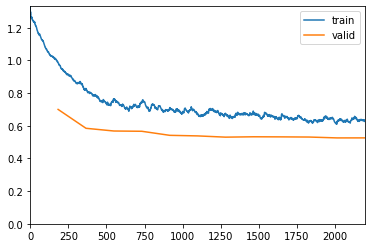

Better model found at epoch 0 with valid_loss value: 0.7002357244491577.
Better model found at epoch 1 with valid_loss value: 0.5846593379974365.
Better model found at epoch 2 with valid_loss value: 0.5680373311042786.
Better model found at epoch 3 with valid_loss value: 0.5663756132125854.
Better model found at epoch 4 with valid_loss value: 0.5415945053100586.
Better model found at epoch 5 with valid_loss value: 0.5380640625953674.
Better model found at epoch 6 with valid_loss value: 0.5304495692253113.
Better model found at epoch 10 with valid_loss value: 0.5257765054702759.


False  --  Embedding(4664, 400, padding_idx=1)
False  --  Embedding(4664, 400, padding_idx=1)
False  --  LSTM(400, 1152, batch_first=True)
False  --  ParameterModule()
False  --  LSTM(1152, 1152, batch_first=True)
False  --  ParameterModule()
False  --  LSTM(1152, 400, batch_first=True)
False  --  ParameterModule()
True  --  BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
True

In [69]:
learn = learn.load_encoder('finetuned')
learn.fit_one_cycle(12, 2e-3)
print('\n')
trainable_layers(learn)

SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=2.75422871709452e-06)

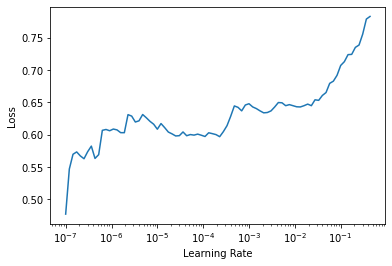

In [70]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.697361,0.554290,0.773566,0.773566,00:19
1,0.624794,0.521592,0.796107,0.796107,00:19
2,0.571623,0.502091,0.804986,0.804986,00:19
3,0.473452,0.503387,0.804986,0.804986,00:19
4,0.411995,0.514737,0.806694,0.806694,00:19


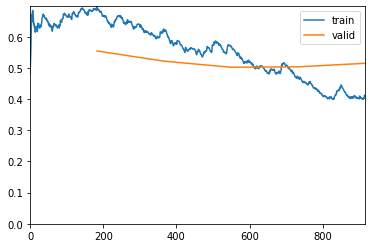

Better model found at epoch 0 with valid_loss value: 0.5542899966239929.
Better model found at epoch 1 with valid_loss value: 0.521592378616333.
Better model found at epoch 2 with valid_loss value: 0.502090573310852.


False  --  Embedding(4664, 400, padding_idx=1)
False  --  Embedding(4664, 400, padding_idx=1)
False  --  LSTM(400, 1152, batch_first=True)
False  --  ParameterModule()
False  --  LSTM(1152, 1152, batch_first=True)
False  --  ParameterModule()
True  --  LSTM(1152, 400, batch_first=True)
True  --  ParameterModule()
True  --  BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
True  --  Linear(in_features=1200, out_features=50, bias=False)
True  --  BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
True  --  Linear(in_features=50, out_features=3, bias=False)


In [71]:
# REFINING 1
learn.load('model')
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2))
print('\n')
trainable_layers(learn)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.499586,0.492810,0.813525,0.813525,00:20
1,0.435770,0.515791,0.818648,0.818648,00:20
2,0.344844,0.551675,0.813183,0.813183,00:20


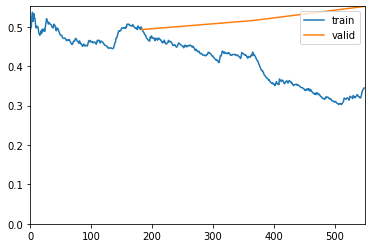

Better model found at epoch 0 with valid_loss value: 0.4928099811077118.


False  --  Embedding(4664, 400, padding_idx=1)
False  --  Embedding(4664, 400, padding_idx=1)
False  --  LSTM(400, 1152, batch_first=True)
False  --  ParameterModule()
True  --  LSTM(1152, 1152, batch_first=True)
True  --  ParameterModule()
True  --  LSTM(1152, 400, batch_first=True)
True  --  ParameterModule()
True  --  BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
True  --  Linear(in_features=1200, out_features=50, bias=False)
True  --  BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
True  --  Linear(in_features=50, out_features=3, bias=False)


In [72]:
# REFINING 2
learn.load('model')
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3))
print('\n')
trainable_layers(learn)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.397391,0.500124,0.814208,0.814208,00:21
1,0.368652,0.503436,0.814891,0.814891,00:21


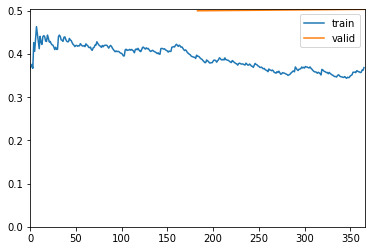

Better model found at epoch 0 with valid_loss value: 0.5001243352890015.


True  --  Embedding(4664, 400, padding_idx=1)
True  --  Embedding(4664, 400, padding_idx=1)
True  --  LSTM(400, 1152, batch_first=True)
True  --  ParameterModule()
True  --  LSTM(1152, 1152, batch_first=True)
True  --  ParameterModule()
True  --  LSTM(1152, 400, batch_first=True)
True  --  ParameterModule()
True  --  BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
True  --  Linear(in_features=1200, out_features=50, bias=False)
True  --  BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
True  --  Linear(in_features=50, out_features=3, bias=False)


In [73]:
# REFINING 3
learn.load('model')
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))
print('\n')
trainable_layers(learn)

We reach an accuracy of 83% fo tweet classification, not bad! 

You can now test the language model; you can use it to create inventend sentences and see if they make sense. The more the invented sentences look like made by a person the better trained the language model.

In [74]:
learner = learner.load('language_model')

In [75]:
learner.predict("Never", 15, temperature=0.75) 

"Never flying with them again , so they do n't know what to do with that"

## Statistics of the training

In [77]:
list(learner.activation_stats.stats)

[]

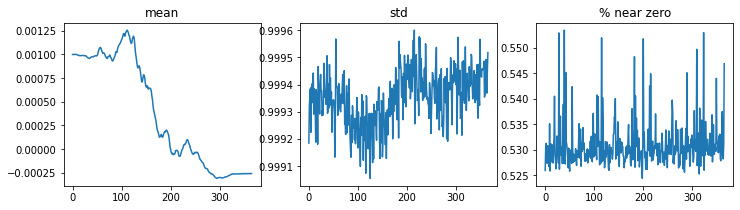

In [ ]:
learner.activation_stats.plot_layer_stats(8)

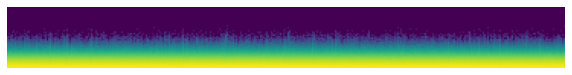

In [ ]:
learner.activation_stats.color_dim(8)

## Asses model performance

In [78]:
n= 1392
learn.predict(tweets.text[n]), tweets.airline_sentiment[n]

(('negative', TensorText(0), TensorText([0.9753, 0.0221, 0.0026])), 'negative')

In [79]:
tweets.text[n]

'@united I am a loyal Premier Platinum member, but the lack of communication was really bad. Also, i don’t see that it has taken off yet'

In [80]:
clas_int = ClassificationInterpretation.from_learner(learn)

Here you can see that there is a Bias wtr to negative classification. This is because in the dataset most of the tweets are negative!

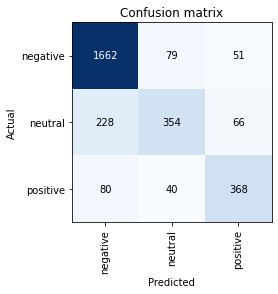

In [81]:
clas_int.plot_confusion_matrix()

In [82]:
clas_int.print_classification_report()

              precision    recall  f1-score   support

    negative       0.84      0.93      0.88      1792
     neutral       0.75      0.55      0.63       648
    positive       0.76      0.75      0.76       488

    accuracy                           0.81      2928
   macro avg       0.78      0.74      0.76      2928
weighted avg       0.81      0.81      0.81      2928



In [83]:
clas_int.top_losses()

torch.return_types.topk(values=TensorText([9.3969e+00, 8.7445e+00, 8.6144e+00,  ..., 7.9867e-05, 7.7483e-05,
        3.1948e-05]), indices=TensorText([1289,  243, 1511,  ..., 1292,  972, 2587]))

In [ ]:
tc_dls.vocab[1]

(#3) ['negative','neutral','positive']

In [85]:
preds = learn.get_preds(dl=tc_dls[1], with_input=True, with_loss=True, with_decoded=True, act=None)

The variable predicts contains the following information: 

0.   inputs
1.   predictions
2.   targets
3. decoded
4. losses

In [ ]:
torch.sum(preds[3] == preds[2]).item()/len(preds[3])

0.8244535519125683

In [89]:
matches = preds[3] == preds[2]

In [90]:
decoded_valid = L(zip(lm_dls.valid_ds.decode(preds[0]),
                      list(map(lambda x: tc_dls.vocab[1][x], preds[2].tolist())),
                      list(map(lambda x: tc_dls.vocab[1][x], preds[3].tolist()))))

In [91]:
df = pd.DataFrame(list(decoded_valid[~matches]), columns =['tweet', 'Truth', 'Computed']) 

In [ ]:
display(HTML(df.to_html(index=False)))

In order to know if we are getting a good performance, we can compare our model training to a benchmark. We can use the IMDB dataset from fastai and see if we get a similar performance or not. 

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)
imdb = pd.read_csv(path/'texts.csv')

In [ ]:
imdb.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


In [ ]:
imdb_cls  = TextDataLoaders.from_df(imdb, text_col='text', label_col='label')
imdb_lm = TextDataLoaders.from_df(imdb, text_col='text', is_lm=True)

We can compare how similar are the features of both datasets, for example we can check how many words does any review contain compared to how many words do the tweets contain.

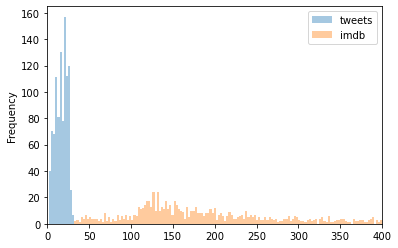

In [ ]:
pd.concat([tweets.text[:1000].apply(lambda s: len(s.split())),
           imdb.text.apply(lambda s: len(s.split()))],
           axis=1,
           keys=['tweets', 'imdb']).plot.hist(alpha=0.4, bins = 500, xlim=(0,400)) 

So we can check the words per tweet or the words per review:

In [ ]:
tweets.text.apply(lambda s: len(s.split())).mean(), imdb.text.apply(lambda s: len(s.split())).mean()

(17.65341530054645, 247.797)

Eventhough the words per tweet are much less, the total amount of words is almost teh same:

In [ ]:
tweets.text.apply(lambda s: len(s.split())).sum(), imdb.text.apply(lambda s: len(s.split())).sum()

(258446, 247797)

In [ ]:
258446/247797

1.042974692994669

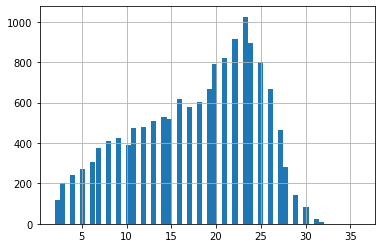

In [ ]:
tweets.text.apply(lambda s: len(s.split())).hist(bins=60)

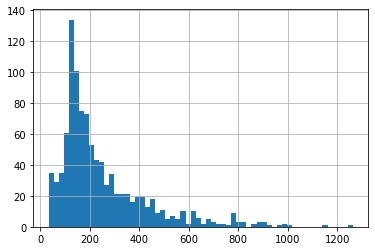

In [ ]:
imdb.text.apply(lambda s: len(s.split())).hist(bins=60)

As we can see the reviews are in general much bigger than the tweets, something that is already expected but can influence the performance of the training.

Another thing to analyze is the vocabs, is the vocab from `imdb` much bigger than from the `tweets`?

In [ ]:
len(lm_dls.vocab), len(imdb_lm.vocab)

(4688, 7080)

As we can see the vocab of `imdb` is almost the double as the vocab for the `tweets`, therefore it could be that the language model for the `imdb` performs better.

In order to simplify things, I will just define a function that does everything we have done so far:

In [ ]:
def complete_training(lm_dls, cl_dls, cbs=None):

    if cbs==None:
        cbs = [
              ShowGraphCallback,
              ActivationStats,
              SaveModelCallback
            ]

    learner = language_model_learner(lm_dls, AWD_LSTM, cbs = cbs,  metrics=[accuracy])
    # TRY CHANGING drop_mult, to see if there is an effect in training small datasets
    learn = text_classifier_learner(cl_dls, AWD_LSTM, drop_mult=0.5, cbs=cbs, metrics=accuracy).to_fp16()

    # ----  TRAIN THE LANGUAGE MODEL  ----
    learner.fit_one_cycle(10, 2e-2)
    # learner.save('language_model')
    learner.save_encoder('finetuned')

    # ----  TRAIN THE CLASSIFIER  ----
    learn = learn.load_encoder('finetuned')
    learn.fit_one_cycle(12,  2e-3)

    # REFINING 1
    learn.freeze_to(-2)
    learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2))

    # REFINING 2
    learn.freeze_to(-3)
    learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3))

    # REFINING 3
    learn.unfreeze()
    learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

    learner.remove_cb(ShowGraphCallback)
    learn.remove_cb(ShowGraphCallback)

    return learner, learn

In [ ]:
learner_imdb, learn_imdb = complete_training(imdb_lm, imdb_cls)